# Assignment objective

We have data from Raleigh, NC, where we recently deployed a flyer program in order to increase public awareness of the possibility of taking a Pagaya loan. You objective is to assess the potency of the flyer program in terms of activation by analyzing production and TU data obtained from the town.


# Basic imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings("ignore")

# Data preparation

## Data from TU 

To begin with, upload TUs credit information from the relevant quarter (which is 2018Q3). This data is available in our `s3` path under the name `tu_gen_data2018Q3.parquet`. To get to our `s3` path import `DATA_FILES_PATH` from `pagayapro.paths.data_paths`

In [2]:
from pagayapro.paths.data_paths import DATA_FILES_PATH

read the parquet file from `s3`. Only read the columns ["sequence_num", "credit_score", "listing_term", "int_rate", "loan_amnt", "monthly_pmt", "original_state"]

In [3]:
tu_data= pd.read_parquet(
    os.path.join(DATA_FILES_PATH,"tu_gen_data_2018Q3.parquet"),
                columns = ["sequence_num", "credit_score", 
                           "listing_term", "int_rate" ,
                           "loan_amnt", "monthly_pmt", 
                           "original_state"])

Output the first 5 rows of tu_data

In [4]:
tu_data.head()

,sequence_num,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
id,,,,,,,
adf5219e4cb985352184eb7fa597737e4a9777f7354f7a8a58270da147792561,d0820401b209782dae4284b3dd96b41e08c3e8566fbb33...,814,36.0,7.86,5500.0,172.0,MI
0a0f130443af4c6597bb074942970eaddeb125d398e2cca42175c56befc8a171,2f05cd66cb998e5e55f6f296344b271b2b89b996c7c037...,800,36.0,7.91,20000.0,626.0,NM
4ba9c6a38b650ee06b8b88a48621bd363cdf611e63400c6fc4bbffbd1bf20c47,20bdbfaf0006db032d8a4176add08fd4ef45abfb17c474...,653,36.0,30.51,3674.0,157.0,SD
dae3a344292e07d4b8935a453c37aef01303f21b2f37ccbd1c4408f158533acb,53084498c6bf053a4d1cf309e1b8ec234e503bb1a3dd4e...,623,60.0,23.46,14056.0,400.0,NC
8af2ae2462d012e4d85aa687a16a4f5fb64525928235da43c795f73dc0cadd04,f750c4ecac12ae1c156998ed3dff3f46d2d19f37250074...,627,60.0,25.55,8659.0,257.0,TN


## Activation data 

Your data regarding activation arrives as forms, detailing the loan amount, interest rate offered to the client and whether he or she accepted the offer. These are available on the assignment's `s3` path, which you can import from `pagayapro.path.data_paths` under the name `ASSIGNMENT1_DATA`, in the subdirectory `offers`. 

In [5]:
from pagayapro.paths.data_paths import ASSIGNMENT1_DATA
import glob

Read all files in the subdirectory `offers` of `ASSIGNMENT1_DATA` whose name contains the substring `raleigh`.

In [6]:
raleigh_forms= (
    glob.glob(
        os.path.join(ASSIGNMENT1_DATA,"offers/*raleigh*")
    )
)

how many forms are there?


In [7]:
len(raleigh_forms)

769

Read all the form files and create a table which contains only the last offer given to each borrower. Call this dataframe `raleigh_df`.

In [8]:
raleigh_df = pd.concat([pd.read_csv(form) for form in raleigh_forms])

In [9]:
raleigh_df = raleigh_df.groupby('id').tail(1)

In [10]:
raleigh_df.head()

,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date
0,743200d3e4cc1f6f860e121294248d611350f257a7bc83...,ec10245656d9d89186fb4e5890082eea989d5967752ce7...,3000.0,17.69,False,2018-01-01
1,e3e32f85cd78bb5002ccdc037c1818029f716e7a47911e...,3dcd131256c103fccb61c75cd79ca97fa2b5e31c4ab03e...,6899.0,12.56,False,2018-01-01
2,3a72ae7a82244f811b37c48f57469b708207004f011163...,06c005c5de6ba445d4c709b84611ac2b8542cd5d37221b...,3800.0,12.97,False,2018-01-01
3,ce770273c28ddb4f8637ae423b582f0b1617e0fe7a4880...,c49b3fce67673a9f82ed4ccaa9f75e668db48e775514fc...,13000.0,5.06,False,2018-01-01
4,7eac15c5019d5101e6434ac34202cc974b044c808958c3...,107a5b2ba3853f80df245d8644af08b74d27af77f14292...,9250.0,10.34,False,2018-01-01


How many rows are there in your table? How many distict ids?

In [11]:
f"Number of rows: {len(raleigh_df)}"

'Number of rows: 8792'

In [12]:
f"Number of unique ids: {len(raleigh_df['id'].unique())}"

'Number of unique ids: 8792'

How can you explain the duplicate ids? Sample 5 ids with multiple lines and display them.

There are no duplicate ids in the dataframe as we took the last record from each id.

Drop all lines in the dataframe which contain irrelevant information.

In [13]:
raleigh_df.isnull().sum()

id                       0
sequence_num             0
requested_amount         0
offered_interest_rate    0
offer_accepted           0
offer_date               0
dtype: int64

In [14]:
raleigh_df.describe()

,requested_amount,offered_interest_rate
count,8792.000000,8792.000000
mean,11752.396724,15.524285
std,9534.989444,7.641190
min,500.000000,1.100000
25%,5000.000000,9.850000
50%,9600.000000,13.470000
75%,15000.000000,19.470000
max,200200.000000,39.990000


After dropping the duplicated records, all the data seems relevnt.

What is the average interest rate offered to clients? What is the average among clients who accepted the offer?

In [15]:
print("Interest rate offered average:")
raleigh_df["offered_interest_rate"].mean()

Interest rate offered average:


15.524284576888082

In [16]:
print("Interest rate offered average among accepted offers:")
raleigh_df.loc[raleigh_df['offer_accepted'] == True, 'offered_interest_rate'].mean()

Interest rate offered average among accepted offers:


15.307480314960628

What is the percentage of activation in this dataframe?

In [17]:
f"Percentage of activation in this dataframe: {raleigh_df['offer_accepted'].sum() / len(raleigh_df['offer_accepted']):.2%}"

'Percentage of activation in this dataframe: 8.67%'

Enrich your dataframe with additioanl TU features by merging it with the `tu_data` df. Note that the two dataframe share the `id` and `sequence_num` features.

In [18]:
raleigh_df = raleigh_df.merge(tu_data, on=('id', 'sequence_num'), how='left')
raleigh_df.head()

,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
0,743200d3e4cc1f6f860e121294248d611350f257a7bc83...,ec10245656d9d89186fb4e5890082eea989d5967752ce7...,3000.0,17.69,False,2018-01-01,652,36.0,17.69,3000.0,108.0,NC
1,e3e32f85cd78bb5002ccdc037c1818029f716e7a47911e...,3dcd131256c103fccb61c75cd79ca97fa2b5e31c4ab03e...,6899.0,12.56,False,2018-01-01,735,36.0,12.56,6899.0,231.0,NC
2,3a72ae7a82244f811b37c48f57469b708207004f011163...,06c005c5de6ba445d4c709b84611ac2b8542cd5d37221b...,3800.0,12.97,False,2018-01-01,661,36.0,12.97,3800.0,128.0,NC
3,ce770273c28ddb4f8637ae423b582f0b1617e0fe7a4880...,c49b3fce67673a9f82ed4ccaa9f75e668db48e775514fc...,13000.0,5.06,False,2018-01-01,823,36.0,5.06,13000.0,390.0,NC
4,7eac15c5019d5101e6434ac34202cc974b044c808958c3...,107a5b2ba3853f80df245d8644af08b74d27af77f14292...,9250.0,10.34,False,2018-01-01,728,36.0,10.34,9250.0,300.0,NC


What is the average credit score of the clients? What is the average among clients who accepted the offer?

In [19]:
print(f"Average credit score: {raleigh_df['credit_score'].mean()}")
print(f"Average credit score among clients who accepted the offer: {raleigh_df.loc[raleigh_df['offer_accepted'] == True, 'credit_score'].mean()}")

Average credit score: 689.821542311192
Average credit score among clients who accepted the offer: 702.5446194225722


# Validations

Before we embark on a statistical test, let's do some validations to make sure that the Raleig sample is not somehow distinct from the general population. Our random sample from the general population is the TU data.

Create a histogram to describe the distribution of requested loan amounts in Raleigh and in the general population. Do the distributions look similar? (A good rule-of-thumb for the number of bins to use is the square-root of the number of unique value.)

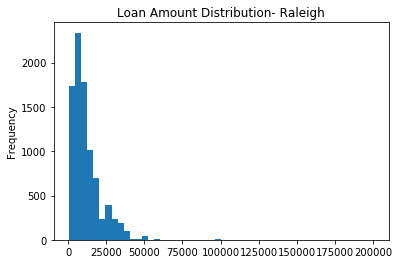

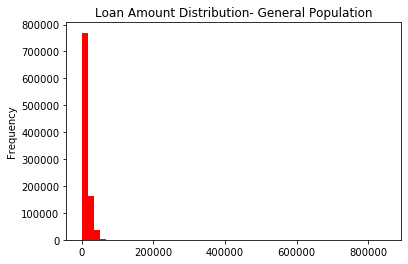

In [20]:
raleigh_df["loan_amnt"].plot.hist(bins=50, title="Loan Amount Distribution- Raleigh", xlabel="Loan Amount")
plt.show()
tu_data["loan_amnt"].plot.hist(bins=50, color='r', title="Loan Amount Distribution- General Population", xlabel="Loan Amount")
plt.show()

In [21]:
raleigh_Q1 = raleigh_df["loan_amnt"].quantile(0.25)
raleigh_Q3 = raleigh_df["loan_amnt"].quantile(0.75)
raleigh_IQR = raleigh_Q3 - raleigh_Q1
raleigh_upper_limit_outliers = raleigh_Q3 + (1.5 * raleigh_IQR)
print(f"The upper limit of outliers in the column loan_amnt according to Raleigh is {raleigh_upper_limit_outliers}")

tu_Q1 = tu_data["loan_amnt"].quantile(0.25)
tu_Q3 = tu_data["loan_amnt"].quantile(0.75)
tu_IQR = tu_Q3 - tu_Q1
tu_upper_limit_outliers = tu_Q3 + (1.5 * tu_IQR)
print(f"The upper limit of outliers in the column loan_amnt according to the general population is {tu_upper_limit_outliers}")


The upper limit of outliers in the column loan_amnt according to Raleigh is 30000.0
The upper limit of outliers in the column loan_amnt according to the general population is 30000.0


In [22]:
print(f"Percentage of Raleigh records with loan amount above upper limit: {len(raleigh_df.loc[raleigh_df['loan_amnt'] > raleigh_upper_limit_outliers]) / len(raleigh_df):.2%}")
print(f"Percentage of Raleigh records with loan amount above upper limit + 10000: {len(raleigh_df.loc[raleigh_df['loan_amnt'] > raleigh_upper_limit_outliers + 10000]) / len(raleigh_df):.2%}")

print(f"Percentage of TU records with loan amount above upper limit: {len(tu_data.loc[tu_data['loan_amnt'] > tu_upper_limit_outliers]) / len(tu_data):.2%}")
print(f"Percentage of TU records with loan amount above upper limit + 10000: {len(tu_data.loc[tu_data['loan_amnt'] > tu_upper_limit_outliers + 10000]) / len(tu_data):.2%}")


Percentage of Raleigh records with loan amount above upper limit: 4.67%
Percentage of Raleigh records with loan amount above upper limit + 10000: 0.91%
Percentage of TU records with loan amount above upper limit: 4.91%
Percentage of TU records with loan amount above upper limit + 10000: 1.01%


We've noticed many outliers in the loan amount column, so we've checked the values accordind to the Interquartile range. 
We've found around 1 percent outliers above 40000, which is considerable for dropping - we'll do that and plot again.

In [23]:
raleigh_df = raleigh_df.loc[raleigh_df['loan_amnt'] <= raleigh_upper_limit_outliers + 10000]
tu_data = tu_data.loc[tu_data['loan_amnt'] <= tu_upper_limit_outliers + 10000]

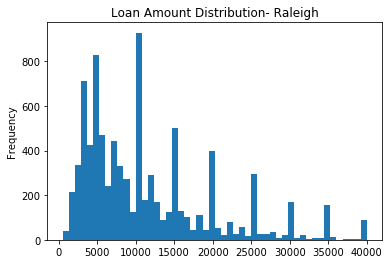

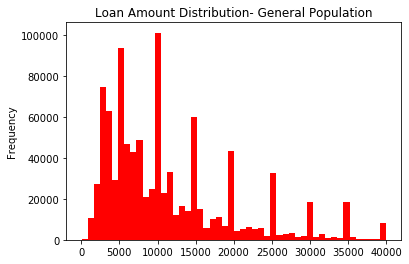

In [24]:
raleigh_df["loan_amnt"].plot.hist(bins=50, title="Loan Amount Distribution- Raleigh", xlabel="Loan Amount")
plt.show()
tu_data["loan_amnt"].plot.hist(bins=50, color='r', title="Loan Amount Distribution- General Population", xlabel="Loan Amount")
plt.show()

Describe the loan amount distribution using `sns.distplot` in the Raleigh dataframe and in TU.

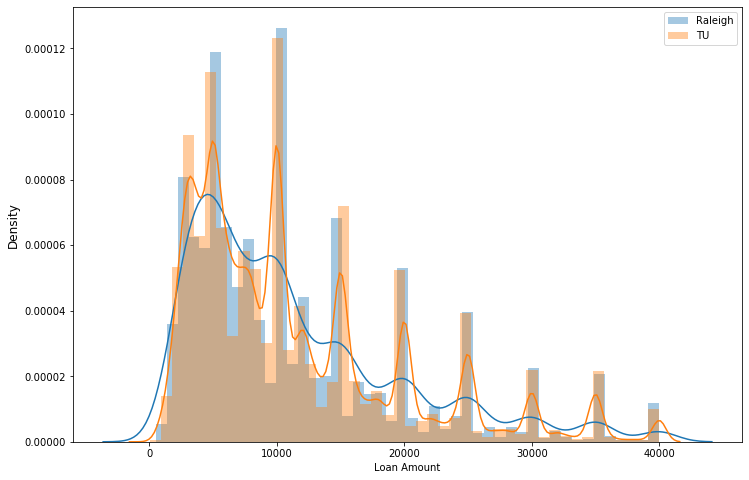

In [25]:
bins_num_raleigh = int(np.sqrt(len(raleigh_df["loan_amnt"].unique())))
# bins_num_tu = int(np.sqrt(len(tu_data["loan_amnt"].unique())))
plt.figure(figsize=(12, 8))
sns.distplot(raleigh_df["loan_amnt"], norm_hist=True, bins=bins_num_raleigh, axlabel='Loan Amount', label='Raleigh')
sns.distplot(tu_data["loan_amnt"], norm_hist=True, bins=bins_num_raleigh, axlabel='Loan Amount', label='TU')
plt.legend()
plt.ylabel('Density', fontsize=12);

We can see in both methods that the distributions look similiar.
Although the kernel density got smoothened in the Raleigh data, the bins look alike and it's probably because of the difference in sizes of the datasets.

We also want to verify that the offered interest rate in Raleigh seem similar to those in the general population. 
Create a histogram to describe the distribution of offered interest rates in Raleigh and interest rates in the general population. Do the distributions look similar?

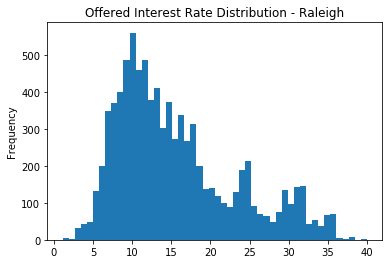

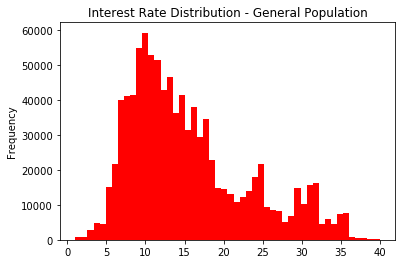

In [26]:
raleigh_df["offered_interest_rate"].plot.hist(bins=50, title="Offered Interest Rate Distribution - Raleigh", xlabel="Offered Interest Rate")
plt.show()
tu_data["int_rate"].plot.hist(bins=50, color='r', title="Interest Rate Distribution - General Population", xlabel="Interest Rate")
plt.show()

Describe the interest rate distribution using `sns.distplot` in the Raleigh dataframe and in TU.

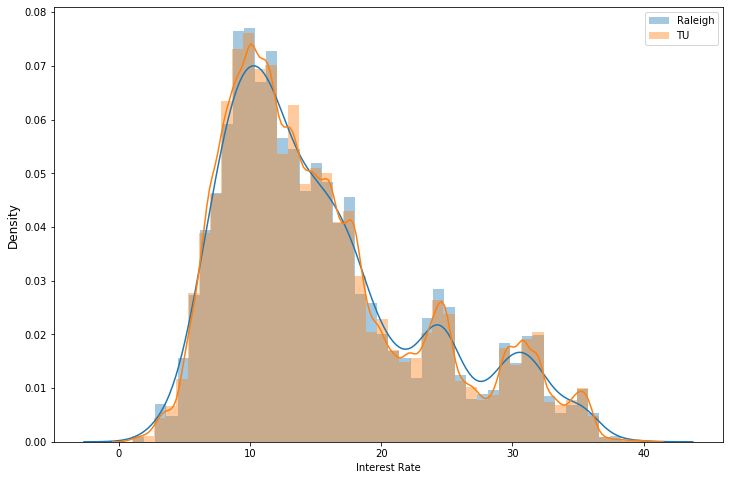

In [27]:
bins_num_raleigh = int(np.sqrt(len(raleigh_df["offered_interest_rate"].unique())))
# bins_num_tu = int(np.sqrt(len(tu_data["int_rate"].unique())))
plt.figure(figsize=(12, 8))
sns.distplot(raleigh_df["offered_interest_rate"], norm_hist=True, bins=bins_num_raleigh, axlabel='Interest Rate', label='Raleigh')
sns.distplot(tu_data["int_rate"], norm_hist=True, bins=bins_num_raleigh, axlabel='Interest Rate', label='TU')
plt.legend()
plt.ylabel('Density', fontsize=12);

We can see even more similiarity in the interest rates between Raleigh and the general population, as the distribution seems almost identical!

Additionally, we want to make sure the credit scores are not visibly different in Raleigh from the general population, as this might mean that the data we obtained from the town might not be representative of the general popuation.

Create a histogram to describe the distribution of credit scores in the Raleigh sample and in the general population. Do the distributions look similar? How many bins did you use?

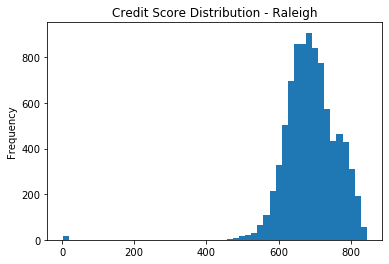

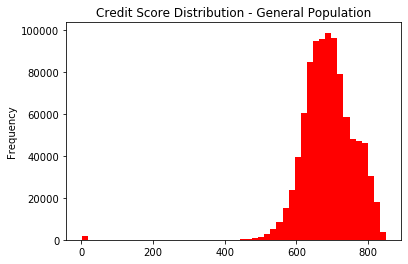

In [28]:
raleigh_df["credit_score"].plot.hist(bins=50, title="Credit Score Distribution - Raleigh", xlabel="Credit Score")
plt.show()
tu_data["credit_score"].plot.hist(bins=50, color='r', title="Credit Score Distribution - General Population", xlabel="Credit Score")
plt.show()

In [29]:
print(f"Percentage of Raleigh clients with credit_score < 300: {len(raleigh_df.loc[raleigh_df['credit_score'] < 300]) / len(raleigh_df):.2%}")
print(f"Percentage of general population clients with credit_score < 300: {len(tu_data.loc[tu_data['credit_score'] < 300]) / len(tu_data):.2%}")

Percentage of Raleigh clients with credit_score < 300: 0.21%
Percentage of general population clients with credit_score < 300: 0.21%


We've noticed that we have clients with very low credit score, as the valid range is between 300 to 850.
In addition we see that the portion of these clients in the data is only 0.2 percent, so we'll just drop those records and plot the distributions again.

In [30]:
raleigh_df = raleigh_df.loc[raleigh_df['credit_score'] >= 300]
tu_data = tu_data.loc[tu_data['credit_score'] >= 300]

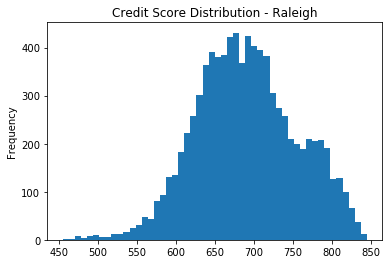

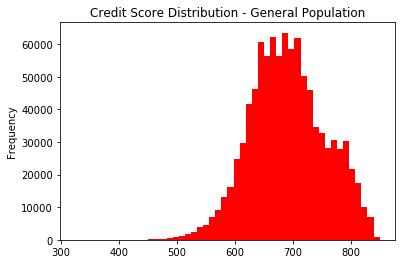

In [31]:
raleigh_df["credit_score"].plot.hist(bins=50, title="Credit Score Distribution - Raleigh", xlabel="Credit Score")
plt.show()
tu_data["credit_score"].plot.hist(bins=50, color='r', title="Credit Score Distribution - General Population", xlabel="Credit Score")
plt.show()

Describe the credit score distribution using `sns.distplot`  in the Raleigh dataframe and in TU.

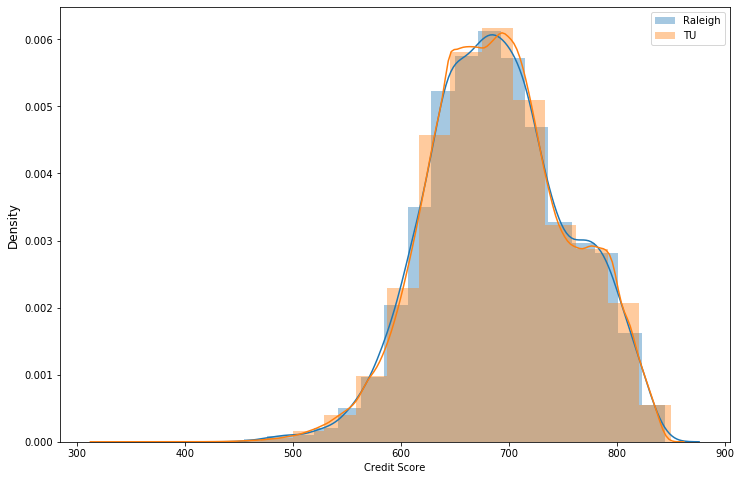

In [32]:
bins_num_raleigh = int(np.sqrt(len(raleigh_df["credit_score"].unique())))
# bins_num_tu = int(np.sqrt(len(tu_data["credit_score"].unique())))
plt.figure(figsize=(12, 8))
sns.distplot(raleigh_df["credit_score"], norm_hist=True, bins=bins_num_raleigh, axlabel='Credit Score', label='Raleigh')
sns.distplot(tu_data["credit_score"], norm_hist=True, bins=bins_num_raleigh, axlabel='Credit Score', label='TU')
plt.legend()
plt.ylabel('Density', fontsize=12);

We can see again large similiarity in the credit scores between Raleigh and the general population, this time there are less low credit scores in Raleigh than in the general population.

Finally, check whether the loans in both datasets have similar distributions of term (i.e. the amount of months the borrower takes the loan for). What values of term exist in the data?

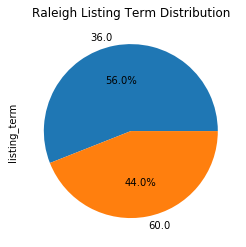

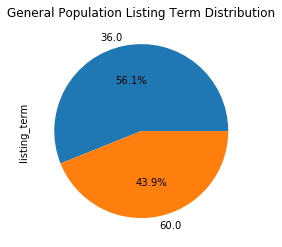

In [33]:
plt.title("Raleigh Listing Term Distribution")
raleigh_df["listing_term"].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

plt.title("General Population Listing Term Distribution")
tu_data["listing_term"].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

There are two options for listing terms: 36 months and 60 months. As we can see from the pie charts - both distributions are (almost) identical!

# CLT in action

One more thing before we start the test. Our goal is to check whether, for which we'll run some statistical test (you probably already know which) which checks if something belongs to a noraml distribution with some mean and some variance. But... is activation normally distributed in the Raliegh sample? 

The activation is a discrete RV which gets values from {0, 1}. It's distribution will be two bars, and it doesn't matter how many samples will we sample - the distribution can't be normal.


The reason why we can assume normality is because we're checking averages of samples and we're relying on the Central Limit Theorem. We won't prove the theorem, but let's test it for a bit. 

Write a function which takes a pandas series S and a natural number n and creates a series of means of samples (with replacement) of n entries from S. Decide for yourself on the length of the output series. You can also use a different data structure if you find it more suitable as the output.

In [34]:
def means_sampling(s, n):
    num_means = int(np.sqrt(len(s)))
    return np.mean(np.random.choice(s.values, size=(num_means, n)), axis=1)

Optionally- also create a function which, given the same input as above, plots a histogram of the series of means, and also indicates the mean of this series.

In [35]:
def means_sampling_plotting(s, n):
    num_means = int(np.sqrt(len(s)))
    s_mean = s.values.mean()
    plt.title(f'Distribution of the Means - Series mean is {s_mean:.3f}, n = {n}')
    plt.xlabel('Mean Value')
    plt.axvline(x=s_mean, label='Input Series Mean', color='r')
    sns.distplot(np.mean(np.random.choice(s.values, size=(num_means, n)), axis=1), label='Means')
    plt.legend()
#     plt.show()

Generate plots of the series of means of activation in Raleigh and in TU for n = 1, 2, 5, 10, 100, 1000 and 1e6, and indicate their means. Does the distribution approach a normal distribution as $n\to\infty$ in your opinion?

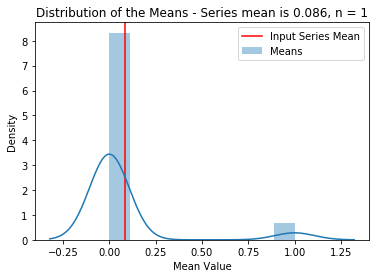

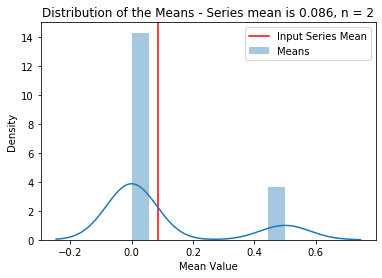

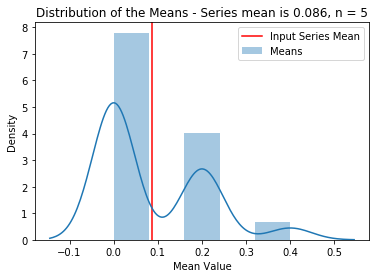

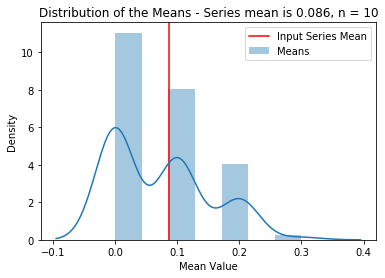

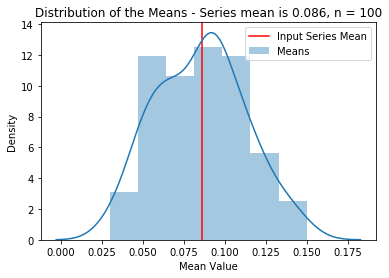

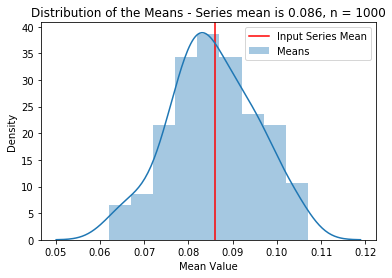

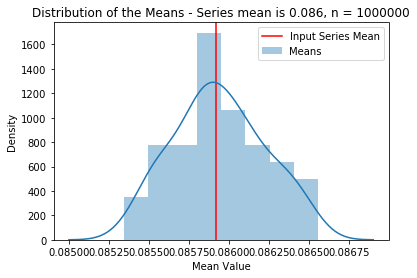

In [36]:
for i in [1, 2, 5, 10, 100, 1000, int(1e6)]:
    means_sampling_plotting(raleigh_df['offer_accepted'], i)
    plt.show()

We can see that as n -> infinity, the distribution goes gaussian more and more with expectency as the series expectency, so yes - CLT is shouting here!

Now that your fuction is ready, it's time to make it part of our infrastucture:
* Inside the `pagayapro` repo, create a branch called `feature/{your_user_name}/clt_tester/`.
* Create a file called `clt.py` inside `~/pagayapro/users/{user_name}/assignment1/` 
* Copy the two finctions you just created into the file.
* Push your file to `main`, open a PR and ask your mentor to review it. Once approved, rebase and merge.

# Statistical test 

As mentioned in the Notion doc, the activation in Raleigh before deployment was measured at 6.85%. In this section, you will run a test to check whether the activation in Raleigh is indeed different following the flyer program. 

In [37]:
from statsmodels.stats.proportion import proportions_ztest


In [156]:
print(f"Current activation rate: {raleigh_df['offer_accepted'].mean():.2%}, {raleigh_df['offer_accepted'].sum()} out of total {len(raleigh_df)} loans offered")

Current activation rate: 8.59%, 747 out of total 8694 loans offered


Run a statistical test to check whether the current activation rate in Raleigh is different from 6,85%:
1. What are your hypotheses?
2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error? What is the power of your test?
3. Is the sample mean significantly different from the past value of 6.85?
4. Interpret your results. Can you declare the program as successful in increasing activation (what is the probability of wrongfully declaring it successful)?
5. Are there any other possible explanations for the change in activation that you observed? Discuss the possible drawbacks of our current test.

Use `proportions_ztestz` from `statsmodels.stats.proportion` in order to perform the test. Are your results significant?

### Hypotheses

1. Our null hypothesys H0 is: The Raleigh's activation rate is 6.85%. \
   Our alternative hypothesys H1 is: The Raleigh's activation rate is different from 6.85%.   

### Error Probabilities

In [38]:
interested_value = 0.0685

alpha = 0.05  # critical statistical significance

_, p_value = proportions_ztest(raleigh_df['offer_accepted'].sum(), len(raleigh_df['offer_accepted']), interested_value)

print(f'2 + 3. P value: {p_value}, Probability for error of type I: {alpha}')

if p_value < alpha:
    print('We reject the null hypothesis! The activation rate is different than 6.85% in confidence level of 95%!')
else:
    print("We can't reject the null hypothesis!") 

2 + 3. P value: 6.780540511082086e-09, Probability for error of type I: 0.05
We reject the null hypothesis! The activation rate is different than 6.85% in confidence level of 95%!


* Let's change our hypotheses, after rejecting the first H0:
H0 stays the same
New H1: The new activation rate is bigger than 6.85%

In [39]:
# one-sided test: p-value will be halved
print('4. Probability for wrongfully declaring it successful: ', alpha)

if (p_value / 2 < alpha) and (raleigh_df['offer_accepted'].mean() > interested_value):
    print('We reject the null hypothesis! The activation rate is higher than 6.85% in confidence level of 95%!')
else:
    print("We can't reject the null hypothesis") 

4. Probability for wrongfully declaring it successful:  0.05
We reject the null hypothesis! The activation rate is higher than 6.85% in confidence level of 95%!


5. There can be many other explanations for the increase in the activation rate! \
    a. Financial situaion got worse for some reason and people need more loans \
    b. Better loans were offered to the clients in comparison to last year \
    c. Other external factors 

Do you see any possible problems in your methodology? What other factors can explain the change in activation, if such a change exists?

* External factors, examples listed in 5 above

# A/b test

In order to isolate temporal and environmental effects on activation, we'll run an a/b test, comparing the activation rate in Raleigh to that of Lubbock, TX, another town in which Pagaya operates without a flyer program. 

The activation forms for Lubbock also appear in the `offers` subdirectory of the `ASSIGNMENT1_DATA` folder. Read all files from this folder whose name contains the substring 'lubbock', and create a dataframe of final offers called `lubbock_df`, drop unnecessary rows from it, and enrich it with TU features.

In [40]:
lubbock_forms= (
    glob.glob(
        os.path.join(ASSIGNMENT1_DATA,"offers/*lubbock*")
    )
)

In [41]:
lubbock_df = pd.concat([pd.read_csv(form) for form in lubbock_forms])
lubbock_df = lubbock_df.groupby('id').tail(1)
lubbock_df = lubbock_df.merge(tu_data, on=('id', 'sequence_num'), how='left')


In [42]:
lubbock_df.head()

,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
0,64796e2ad491e63b299894ddeabb5493e38b7b69770875...,5faf5b8cabb6636e1932f47b51c41e1b12324087fc2e27...,3258.0,17.58,False,2018-01-01,583.0,60.0,17.58,3258.0,82.0,TX
1,38d1be6da80ad94e7a2d226dbe070696c985613dd00f26...,e9d0ce908c56985675d71e793c06b5b6536afd3ba03d86...,16000.0,10.00,False,2018-01-01,692.0,60.0,10.00,16000.0,340.0,TX
2,c751b91bf7b5c2655d7ea397e5a03cbccb74513ff527e4...,f8b6f3cb44cfbb44ad3fa12e6758566a38ef13bbd822bd...,5000.0,18.09,True,2018-01-01,643.0,36.0,18.09,5000.0,181.0,TX
3,ed81efb2125c12ae73c92b36dad9f050c33f3ba3d98b42...,3aad64fa40af5bce4d473f7a38a360de1a2b6dc2b0284d...,9149.0,10.13,False,2018-01-01,529.0,60.0,10.13,9149.0,195.0,TX
4,fb9780f1d54cf106cc5d371a7e2436e586759fb25c9bb6...,a7bf579d73703d66fe7481fe9b2d3c0061171ed87a718b...,3500.0,9.42,False,2018-01-01,698.0,36.0,9.42,3500.0,112.0,TX


In [43]:
lubbock_df.isnull().sum()

id                         0
sequence_num               0
requested_amount           0
offered_interest_rate      0
offer_accepted             0
offer_date                 0
credit_score             123
listing_term             123
int_rate                 123
loan_amnt                123
monthly_pmt              123
original_state           123
dtype: int64

In [44]:
lubbock_df.isnull().sum() / lubbock_df.count()

id                       0.000000
sequence_num             0.000000
requested_amount         0.000000
offered_interest_rate    0.000000
offer_accepted           0.000000
offer_date               0.000000
credit_score             0.010985
listing_term             0.010985
int_rate                 0.010985
loan_amnt                0.010985
monthly_pmt              0.010985
original_state           0.010985
dtype: float64

There are around 1% of the data with NA values, which mostly probably came from the initial cleaning of tu_data, so we'll drop those records.

In [45]:
lubbock_df.dropna(inplace=True)

What is the average interest rate in Lubbock? What is it among accepting borrowers?

In [46]:
print(f"Interest rate offered average in Lubbock: {lubbock_df['offered_interest_rate'].mean()}")
print(f"Interest rate offered average among accepted offers in Lubbock: {lubbock_df.loc[lubbock_df['offer_accepted'] == True, 'offered_interest_rate'].mean()}")


Interest rate offered average in Lubbock: 15.54802179155131
Interest rate offered average among accepted offers in Lubbock: 13.564802259887005


What is the average credit score in Lubbock? What is it among accepting borrowers?

In [47]:
print(f"Average credit score in Lubbock: {lubbock_df['credit_score'].mean()}")
print(f"Average credit score among clients who accepted the offer in Lubbock: {lubbock_df.loc[lubbock_df['offer_accepted'] == True, 'credit_score'].mean()}")

Average credit score in Lubbock: 691.0992230061623
Average credit score among clients who accepted the offer in Lubbock: 730.352165725047


What is the rate of activation in Lubbock?

In [158]:
f"Percentage of activation in Lubbock: {lubbock_df['offer_accepted'].mean():.2%}, {lubbock_df['offer_accepted'].sum()} out of total {len(lubbock_df['offer_accepted'])} loans offered"

'Percentage of activation in Lubbock: 4.74%, 531 out of total 11197 loans offered'

## Caution about a/b test 

Note that this is not a classical a/b test. Usually, in such a test, one creates two random subgroups from the general population and applies a manipulation to one of them in order to see if the manipulation had an effect. However, in this case, it is very complicated to isolate a random subgroup from any population and deploy the flyer program only on it.
Thus, due to production limitation, we have to make do with what we got.

In order to justify the use of an a/b test for this situation, we should at least verify that the borrower population in Lubbock and Raleigh seem as though they were randomly selected from the general population. We have actually already checked it for Raleigh above. Add TU features to the loan amount, interest rate, credit score and term comparisons and see if there any major differences between the three populations (Lubbock, Raleigh and TU).

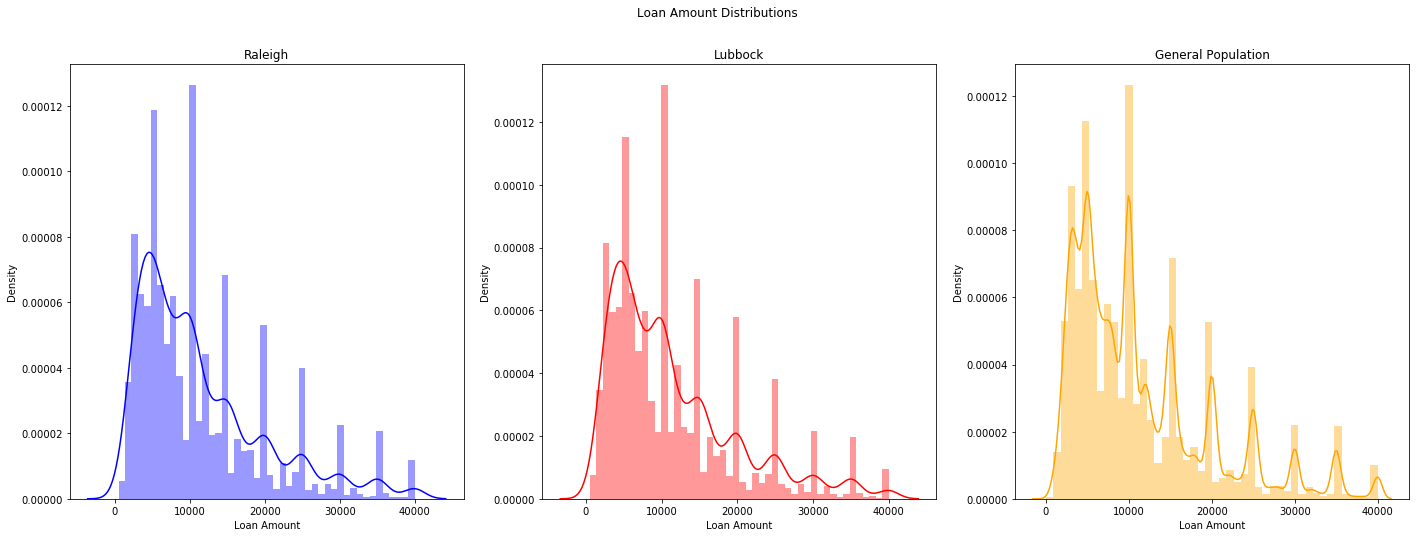

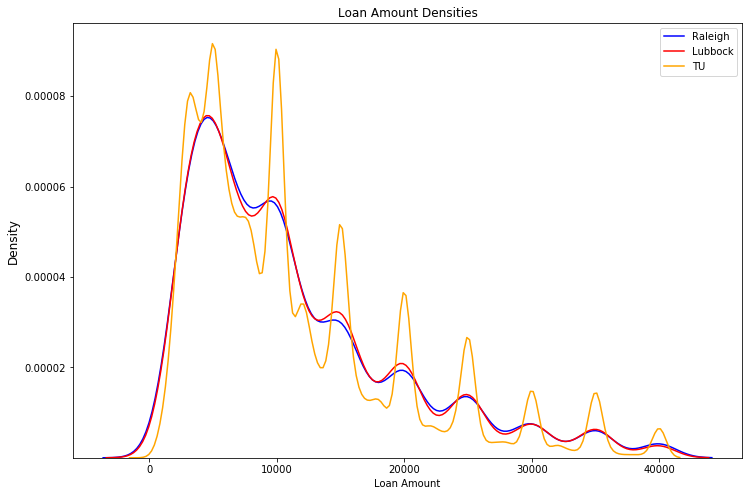

In [49]:
bins_num_raleigh = int(np.sqrt(len(raleigh_df["loan_amnt"].unique())))

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Loan Amount Distributions')
sns.distplot(raleigh_df['loan_amnt'], norm_hist=True, bins=bins_num_raleigh, axlabel='Loan Amount', label='Raleigh', ax=axes[0], color='blue')
axes[0].set_title('Raleigh')
sns.distplot(lubbock_df["loan_amnt"], norm_hist=True, bins=bins_num_raleigh, axlabel='Loan Amount', label='Lubbock', ax=axes[1], color='red')
axes[1].set_title('Lubbock')
sns.distplot(tu_data["loan_amnt"], norm_hist=True, bins=bins_num_raleigh, axlabel='Loan Amount', label='TU', ax=axes[2], color='orange')
axes[2].set_title('General Population')
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Loan Amount Densities')
sns.distplot(raleigh_df["loan_amnt"], norm_hist=True, bins=bins_num_raleigh, axlabel='Loan Amount', label='Raleigh', hist=False, color='blue')
sns.distplot(lubbock_df["loan_amnt"], norm_hist=True, bins=bins_num_raleigh, axlabel='Loan Amount', label='Lubbock', hist=False, color='red')
sns.distplot(tu_data["loan_amnt"], norm_hist=True, bins=bins_num_raleigh, axlabel='Loan Amount', label='TU', hist=False, color='orange')
plt.legend()
plt.ylabel('Density', fontsize=12);
plt.show()


* We can see from the kde how the Raleigh and Lubbock distribution are similiar! All three datasets are distributed similiarily, except that in the General poplulation the peaks are more significant

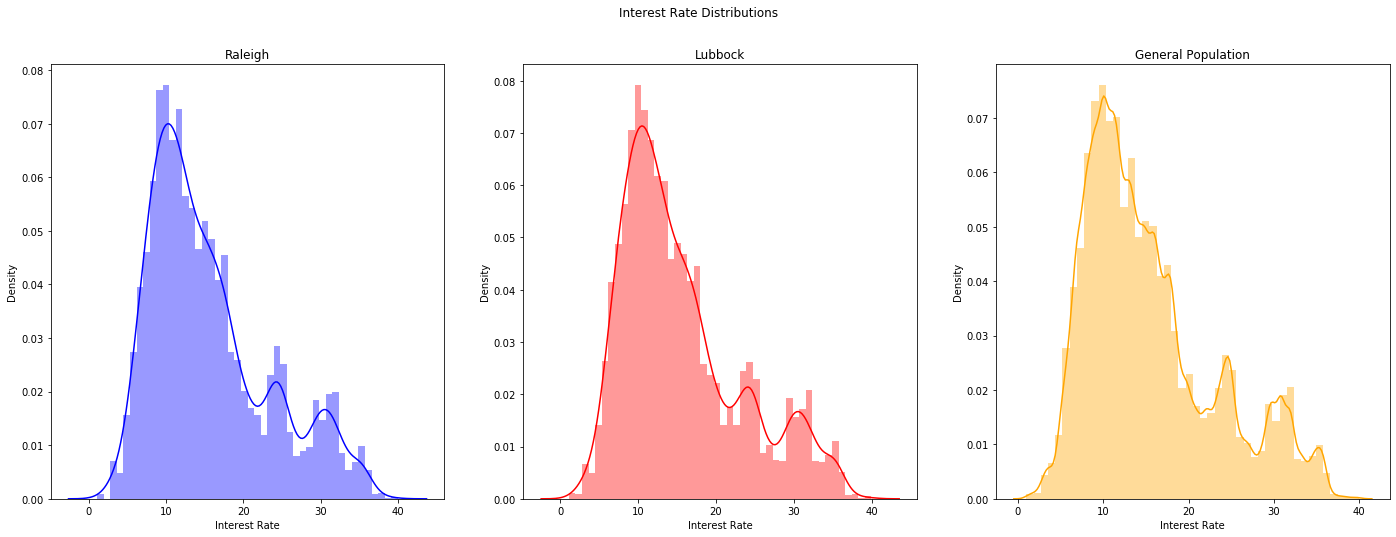

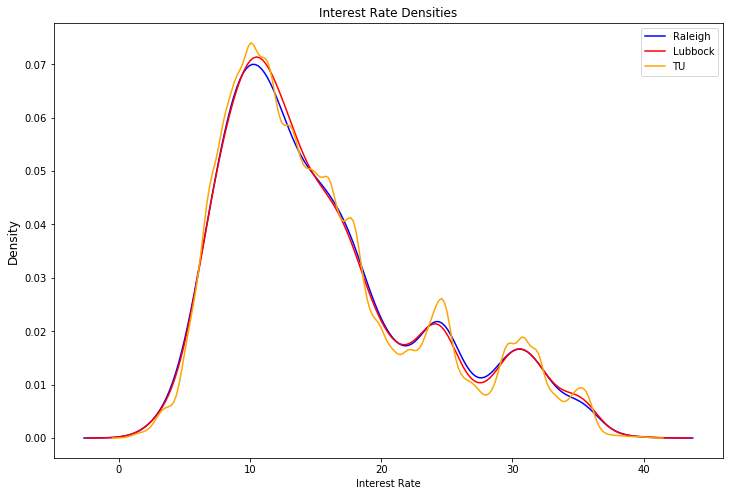

In [50]:
bins_num_raleigh = int(np.sqrt(len(raleigh_df["offered_interest_rate"].unique())))

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Interest Rate Distributions')
sns.distplot(raleigh_df['offered_interest_rate'], norm_hist=True, bins=bins_num_raleigh, axlabel='Interest Rate', label='Raleigh', ax=axes[0], color='blue')
axes[0].set_title('Raleigh')
sns.distplot(lubbock_df["offered_interest_rate"], norm_hist=True, bins=bins_num_raleigh, axlabel='Interest Rate', label='Lubbock', ax=axes[1], color='red')
axes[1].set_title('Lubbock')
sns.distplot(tu_data["int_rate"], norm_hist=True, bins=bins_num_raleigh, axlabel='Interest Rate', label='TU', ax=axes[2], color='orange')
axes[2].set_title('General Population')
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Interest Rate Densities')
sns.distplot(raleigh_df["offered_interest_rate"], norm_hist=True, bins=bins_num_raleigh, axlabel='Interest Rate', label='Raleigh', hist=False, color='blue')
sns.distplot(lubbock_df["offered_interest_rate"], norm_hist=True, bins=bins_num_raleigh, axlabel='Interest Rate', label='Lubbock', hist=False, color='red')
sns.distplot(tu_data["int_rate"], norm_hist=True, bins=bins_num_raleigh, axlabel='Interest Rate', label='TU', hist=False, color='orange')
plt.legend()
plt.ylabel('Density', fontsize=12);
plt.show()


* We can see from the kde and from the histogram bins how all the three distribution are similiar and almost identical! 

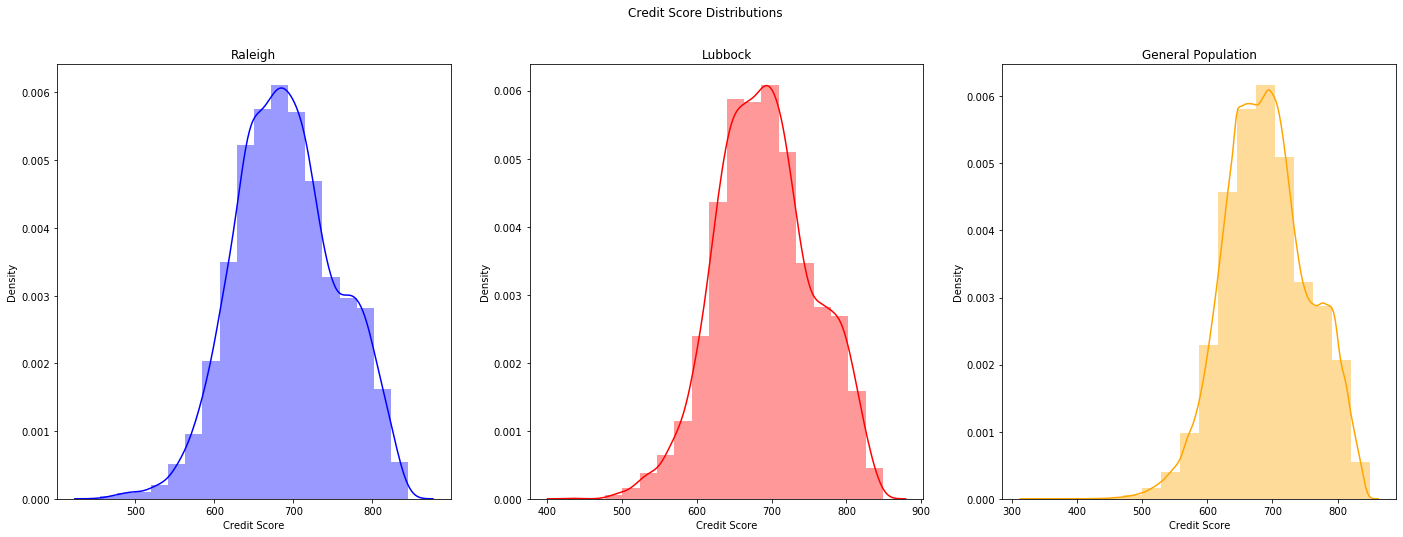

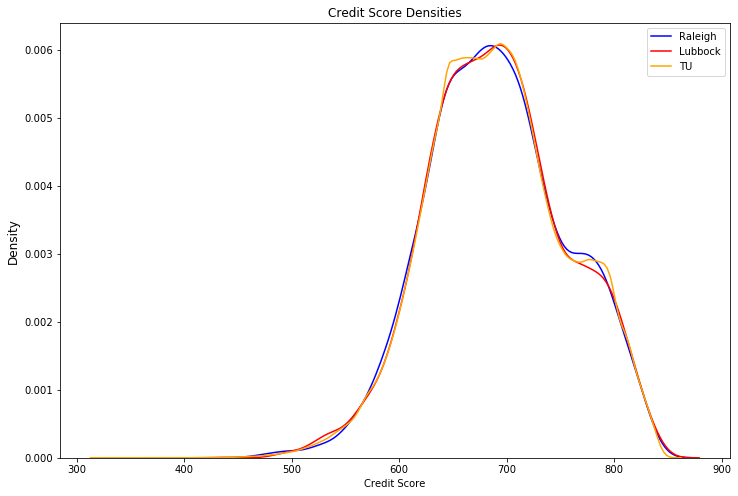

In [51]:
bins_num_raleigh = int(np.sqrt(len(raleigh_df["credit_score"].unique())))

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Credit Score Distributions')
sns.distplot(raleigh_df['credit_score'], norm_hist=True, bins=bins_num_raleigh, axlabel='Credit Score', label='Raleigh', ax=axes[0], color='blue')
axes[0].set_title('Raleigh')
sns.distplot(lubbock_df["credit_score"], norm_hist=True, bins=bins_num_raleigh, axlabel='Credit Score', label='Lubbock', ax=axes[1], color='red')
axes[1].set_title('Lubbock')
sns.distplot(tu_data["credit_score"], norm_hist=True, bins=bins_num_raleigh, axlabel='Credit Score', label='TU', ax=axes[2], color='orange')
axes[2].set_title('General Population')
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Credit Score Densities')
sns.distplot(raleigh_df["credit_score"], norm_hist=True, bins=bins_num_raleigh, axlabel='Credit Score', label='Raleigh', hist=False, color='blue')
sns.distplot(lubbock_df["credit_score"], norm_hist=True, bins=bins_num_raleigh, axlabel='Credit Score', label='Lubbock', hist=False, color='red')
sns.distplot(tu_data["credit_score"], norm_hist=True, bins=bins_num_raleigh, axlabel='Credit Score', label='TU', hist=False, color='orange')
plt.legend()
plt.ylabel('Density', fontsize=12);
plt.show()


* We can see from the kde and from the histogram bins how all the three distribution are similiar and almost identical! \
  We can see from the histogram that there are more low credit scores in the general population in comparison to Raleigh and Lubbock

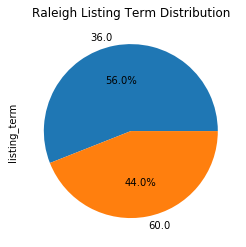

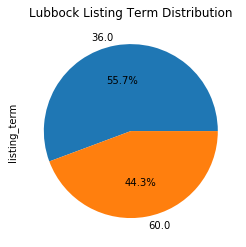

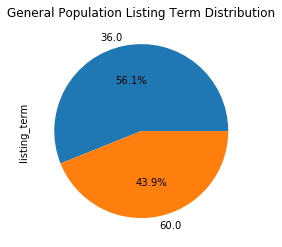

In [141]:
plt.title("Raleigh Listing Term Distribution")
raleigh_df["listing_term"].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

plt.title("Lubbock Listing Term Distribution")
lubbock_df["listing_term"].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

plt.title("General Population Listing Term Distribution")
tu_data["listing_term"].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

* We can see that with minor bias, the three distributions of the listing terms are similar

## Performing the test

Use the function you created in the file `clt.py` to plot the series of means of activation in Raleigh and Lubbock for samples of size n= 1, 10, 1000 and 1e6, and compare the means of the two histograms. To they seem to converge to the same value?

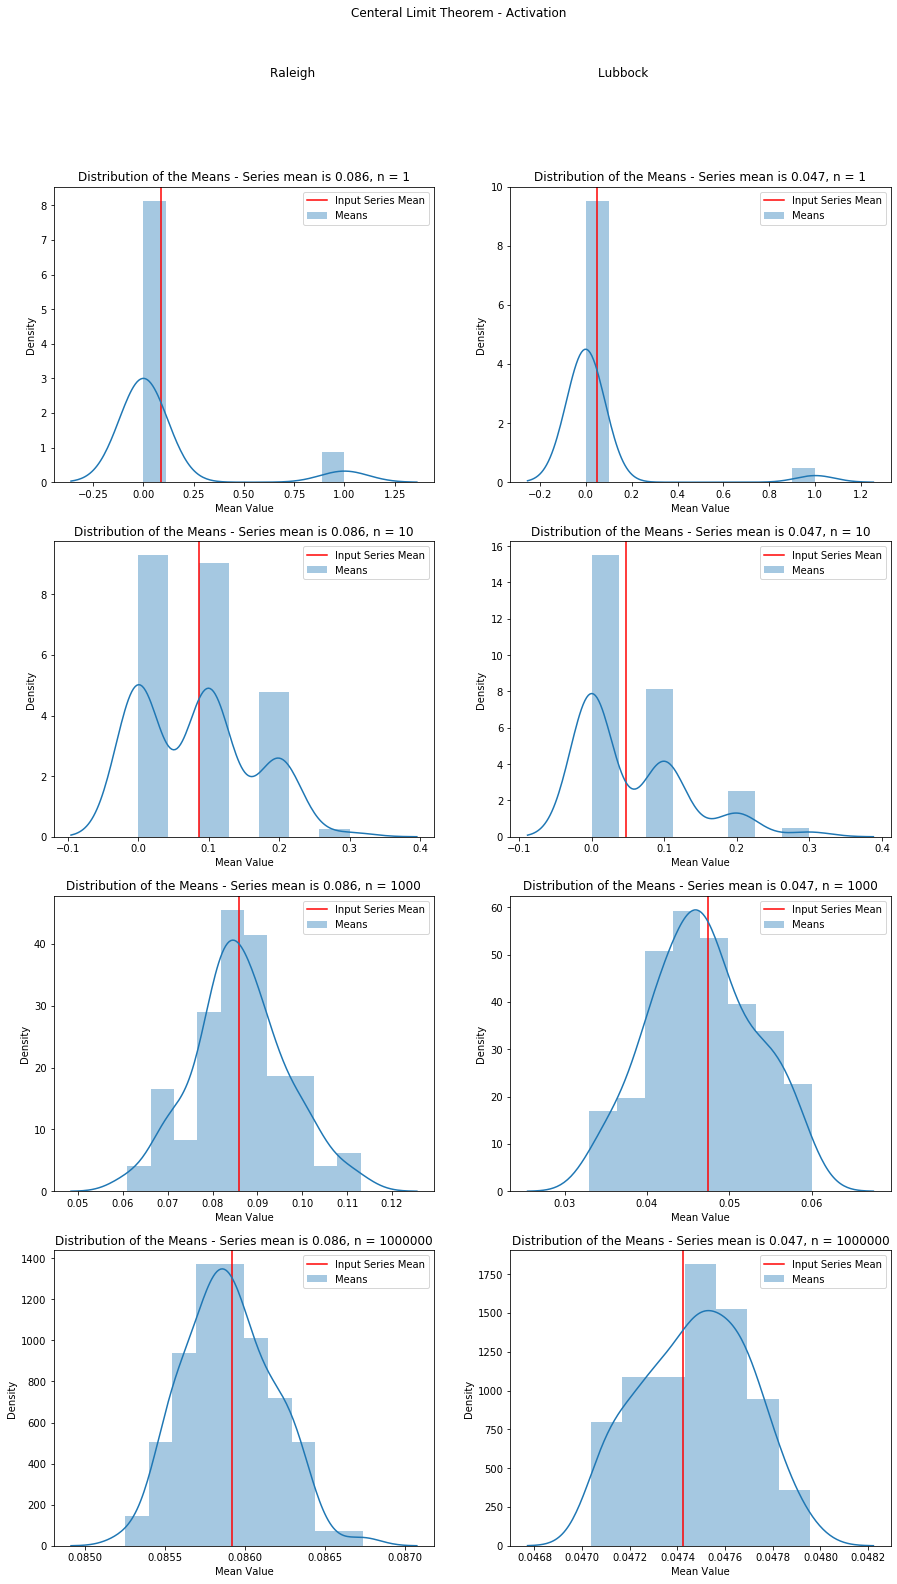

In [52]:
from clt import means_sampling_plotting

plt.figure(figsize=(15,25))
plt.suptitle('Centeral Limit Theorem - Activation\n\n\n\nRaleigh                                                                         Lubbock')

for i, n in enumerate([1, 10, 1000, int(1e6)]):
    plt.subplot(4, 2, 2 * i + 1)
    means_sampling_plotting(raleigh_df['offer_accepted'], n)
    
    plt.subplot(4, 2, 2 * i + 2)
    means_sampling_plotting(lubbock_df['offer_accepted'], n)


Apply a statistical test to see whether the activation rate in Raleigh, NC is significantly larger than Lubbock, TX. Clearly state and validate your test's assumption. 

1. What are your hypotheses?
2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error?
3. Are the two samples significantly different? 
4. Interpret your results. Can you declare the program as successful in increasing activation? What is the probability of wrongfully declaring it successful?

1. Our null hypothesys H0 is: The Raleigh's activation rate is identical to Lubbock activation rate. \
   Our alternative hypothesys H1 is: The Raleigh's activation rate is significantly larger than Lubbock.

Use the `proportions_ztestz` function from `statsmodels.stats.proportion` to perform a comparison between the activation probability in Lubbock and in Raleigh. 

In [53]:
alpha = 0.05  # critical statistical significance

_, p_value = proportions_ztest([raleigh_df['offer_accepted'].sum(), lubbock_df['offer_accepted'].sum()], [len(raleigh_df['offer_accepted']), len(lubbock_df['offer_accepted'])])

print(f'2 + 3. P value: {p_value / 2}, Probability for error of type I: {alpha}')

if p_value / 2 < alpha and raleigh_df['offer_accepted'].mean() > lubbock_df['offer_accepted'].mean():
    print("We reject the null hypothesis! The Raleigh's activation rate is higher than Lubbock's activation rate in confidence level of 95%!")
else:
    print("We can't reject the null hypothesis!") 

2 + 3. P value: 2.28646171510515e-28, Probability for error of type I: 0.05
We reject the null hypothesis! The Raleigh's activation rate is higher than Lubbock's activation rate in confidence level of 95%!


* 4. We showed in confidence level of 95% that the Raleigh's activation rate is higher than Lubbock's activation rate, which states also of course they are different. \
     The probability of wrongfully declaring it successful is the same as the probability for error of type I.

Interprest your results; do you observe a significant change in activation in Raleigh? What is the probability of wrongfully declaring the program successful?

* 5. answered in 4

# Testing for activation in sub-populations

Now that you applied the a/b test to the Lubbock and Raleigh datasets, it is now required that you make a similar comparison on different subsets of the data within various credit score and loan amount bins. To do so, let us first decide on how to segment our data.

You are asked to divide your data into 10 bins according to loan amount, and then divide each of those bins into 10 bins according to loan amount. The most staightforward way of doing this is by using the `pd.qcut` function; first dividing the data into 10 quantiles of credit score and then dividing each of these quantiles into 10 according to loan amount.

Divide your datasets as above and add two columns to your data which indicate the (credit_score, loan_amnt) of the bin.

In [54]:
tu_data['credit_score_range'] = pd.qcut(tu_data['credit_score'], q=10)
tu_data['loan_amount_range'] = tu_data.groupby('credit_score_range')['loan_amnt'].apply(pd.qcut, 10)


In [55]:
raleigh_df = raleigh_df.merge(tu_data[['sequence_num', 'credit_score_range', 'loan_amount_range']], on=('id', 'sequence_num'), how='left')
lubbock_df = lubbock_df.merge(tu_data[['sequence_num', 'credit_score_range', 'loan_amount_range']], on=('id', 'sequence_num'), how='left')

Run an a/b test on each of the bins in your data and create a $10\times 10$ table containing the $p$ value of each test.

As done on the previous a/b tests comparing between Raleigh and Lubbock - our hypotheses are as follows:\
Our null hypothesys H0 is: The Raleigh's activation rate for the specific group (credit_score_range, loan_amnt_range) is identical to Lubbock activation rate.
Our alternative hypothesys H1 is: The Raleigh's activation rate for the specific group (credit_score_range, loan_amnt_range) is significantly larger than Lubbock in the same group.

In [154]:
p_values = np.zeros((10, 10))

raleigh_df_grouped = raleigh_df.groupby(['credit_score_range', 'loan_amount_range'])
lubbock_df_grouped = lubbock_df.groupby(['credit_score_range', 'loan_amount_range'])

groups_mat = np.zeros((10, 10), dtype=tuple)


for i, (group_name, _) in enumerate(tu_data.groupby(['credit_score_range', 'loan_amount_range'])):
    groups_mat[i // 10, i % 10] = ((group_name[0].left, group_name[0].right), (group_name[1].left, group_name[1].right))
    raleigh_group = raleigh_df_grouped.get_group(group_name)
    lubbock_group = lubbock_df_grouped.get_group(group_name)
    
    _, p_value = proportions_ztest([raleigh_group['offer_accepted'].sum(), lubbock_group['offer_accepted'].sum()], [len(raleigh_group['offer_accepted']), len(lubbock_group['offer_accepted'])])
    p_values[i // 10, i % 10] = p_value / 2


print(f"Size of Raleigh one sampled group: {len(raleigh_group)}, Size of Lubbock one sampled group: {len(lubbock_group)}")
pd.DataFrame(groups_mat)

Size of Raleigh one sampled group: 97, Size of Lubbock one sampled group: 118


,0,1,2,3,4,5,6,7,8,9
0,"((324.999, 612.0), (99.999, 2500.0))","((324.999, 612.0), (2500.0, 3043.0))","((324.999, 612.0), (3043.0, 3675.0))","((324.999, 612.0), (3675.0, 4576.0))","((324.999, 612.0), (4576.0, 5291.0))","((324.999, 612.0), (5291.0, 6556.0))","((324.999, 612.0), (6556.0, 8000.0))","((324.999, 612.0), (8000.0, 10000.0))","((324.999, 612.0), (10000.0, 12900.0))","((324.999, 612.0), (12900.0, 40000.0))"
1,"((612.0, 637.0), (44.999, 2700.0))","((612.0, 637.0), (2700.0, 3458.0))","((612.0, 637.0), (3458.0, 4454.2))","((612.0, 637.0), (4454.2, 5070.6))","((612.0, 637.0), (5070.6, 6500.0))","((612.0, 637.0), (6500.0, 8000.0))","((612.0, 637.0), (8000.0, 10000.0))","((612.0, 637.0), (10000.0, 12000.0))","((612.0, 637.0), (12000.0, 15999.0))","((612.0, 637.0), (15999.0, 40000.0))"
2,"((637.0, 655.0), (274.999, 3000.0))","((637.0, 655.0), (3000.0, 4000.0))","((637.0, 655.0), (4000.0, 5000.0))","((637.0, 655.0), (5000.0, 6300.0))","((637.0, 655.0), (6300.0, 8000.0))","((637.0, 655.0), (8000.0, 10000.0))","((637.0, 655.0), (10000.0, 11680.4))","((637.0, 655.0), (11680.4, 15000.0))","((637.0, 655.0), (15000.0, 20000.0))","((637.0, 655.0), (20000.0, 40000.0))"
3,"((655.0, 672.0), (167.999, 3000.0))","((655.0, 672.0), (3000.0, 4500.0))","((655.0, 672.0), (4500.0, 5500.0))","((655.0, 672.0), (5500.0, 7231.2))","((655.0, 672.0), (7231.2, 9500.0))","((655.0, 672.0), (9500.0, 10000.0))","((655.0, 672.0), (10000.0, 13000.0))","((655.0, 672.0), (13000.0, 16000.0))","((655.0, 672.0), (16000.0, 22585.8))","((655.0, 672.0), (22585.8, 40000.0))"
4,"((672.0, 689.0), (274.999, 3200.0))","((672.0, 689.0), (3200.0, 5000.0))","((672.0, 689.0), (5000.0, 6000.0))","((672.0, 689.0), (6000.0, 8000.0))","((672.0, 689.0), (8000.0, 10000.0))","((672.0, 689.0), (10000.0, 11000.0))","((672.0, 689.0), (11000.0, 15000.0))","((672.0, 689.0), (15000.0, 18000.0))","((672.0, 689.0), (18000.0, 25000.0))","((672.0, 689.0), (25000.0, 40000.0))"
5,"((689.0, 705.0), (149.999, 3500.0))","((689.0, 705.0), (3500.0, 5000.0))","((689.0, 705.0), (5000.0, 6000.0))","((689.0, 705.0), (6000.0, 8000.0))","((689.0, 705.0), (8000.0, 10000.0))","((689.0, 705.0), (10000.0, 12000.0))","((689.0, 705.0), (12000.0, 15000.0))","((689.0, 705.0), (15000.0, 19300.0))","((689.0, 705.0), (19300.0, 25000.0))","((689.0, 705.0), (25000.0, 40000.0))"
6,"((705.0, 723.0), (44.999, 3500.0))","((705.0, 723.0), (3500.0, 5000.0))","((705.0, 723.0), (5000.0, 6471.9))","((705.0, 723.0), (6471.9, 8500.0))","((705.0, 723.0), (8500.0, 10000.0))","((705.0, 723.0), (10000.0, 12000.0))","((705.0, 723.0), (12000.0, 15000.0))","((705.0, 723.0), (15000.0, 20000.0))","((705.0, 723.0), (20000.0, 25000.0))","((705.0, 723.0), (25000.0, 40000.0))"
7,"((723.0, 749.0), (149.999, 4000.0))","((723.0, 749.0), (4000.0, 5017.4))","((723.0, 749.0), (5017.4, 7106.8))","((723.0, 749.0), (7106.8, 10000.0))","((723.0, 749.0), (10000.0, 10500.0))","((723.0, 749.0), (10500.0, 14200.0))","((723.0, 749.0), (14200.0, 16322.0))","((723.0, 749.0), (16322.0, 20012.0))","((723.0, 749.0), (20012.0, 27500.0))","((723.0, 749.0), (27500.0, 40000.0))"
8,"((749.0, 783.0), (399.999, 4000.0))","((749.0, 783.0), (4000.0, 5500.0))","((749.0, 783.0), (5500.0, 7500.0))","((749.0, 783.0), (7500.0, 10000.0))","((749.0, 783.0), (10000.0, 11500.0))","((749.0, 783.0), (11500.0, 15000.0))","((749.0, 783.0), (15000.0, 17500.0))","((749.0, 783.0), (17500.0, 21000.0))","((749.0, 783.0), (21000.0, 28300.0))","((749.0, 783.0), (28300.0, 40000.0))"
9,"((783.0, 850.0), (173.999, 4000.0))","((783.0, 850.0), (4000.0, 5095.0))","((783.0, 850.0), (5095.0, 7000.0))","((783.0, 850.0), (7000.0, 10000.0))","((783.0, 850.0), (10000.0, 10100.0))","((783.0, 850.0), (10100.0, 14000.0))","((783.0, 850.0), (14000.0, 16000.0))","((783.0, 850.0), (16000.0, 20000.0))","((783.0, 850.0), (20000.0, 25596.5))","((783.0, 850.0), (25596.5, 40000.0))"


Use the [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function to represent your table as a heatmap. You can also use it on a suitable table of boolean values to get a more robus representation of which experiments turned out significant.

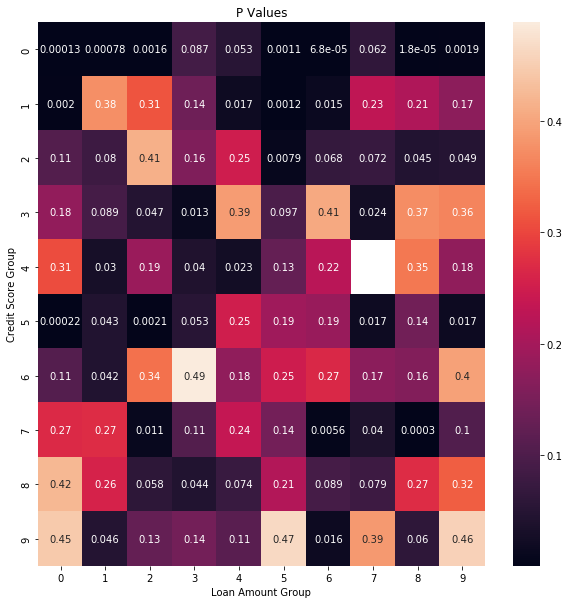

In [57]:
plt.figure(figsize=(10, 10))
plt.title('P Values')
sns.heatmap(p_values, annot=True)
plt.xlabel('Loan Amount Group')
plt.ylabel('Credit Score Group');

What is the probability of falsely rejecting the null hypothesis in each cell? What is the probability of falsely rejecting the null hypothesis in at least one of the cells (i.e. what is the **family wise error rate**)?

In other words, given that we made $m$ experiments, with confidence level $\alpha$, what is the probabilty $\mathbb{P}\left(\bigcup_i X_i \le q_{\alpha}\right)$? 

_Note_: you may assume that sampling from different bins are independent.

The probability of falsely rejecting the null hypothesis in each cell is alpha. \
the probability of falsely rejecting the null hypothesis in at least one of the cells is 1-( (1-alpha)^m ) (given sampling from different bins are independent) \
For alpha = 0.05 and m = 100 the calculations are below:

In [58]:
fwer = 1 - (1 - alpha) ** 100
print(f"FWER = {fwer}")

FWER = 0.994079470779666


## Bonferroni correction 

One way of assuring that your FWER remains below $\alpha=0.05$ is to apply a <a href="https://en.wikipedia.org/wiki/Bonferroni_correction">**Bonferroni correction**</a>. This means that we set the signficance level of each individual test to $\alpha/m$, where $m=100$ is the number of tests (see, e.g., Wikipedia for an explanation). 

Use a Bonferroni correction on your segmented a/b test and output a $10\times10$ table of boolean values, indicating which test gave a significant result under this correction.

In [59]:
bonferroni = p_values < (alpha / 100)
bonferroni


array([[ True, False, False, False, False, False,  True, False,  True,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [ True, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False,  True,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False]])

How many of your tests came out significant under this correction?

In [99]:
print(f"Number of tests came out significant under Bonferroni correction: {bonferroni.sum()}")

Number of tests came out significant under Bonferroni correction: 5


Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

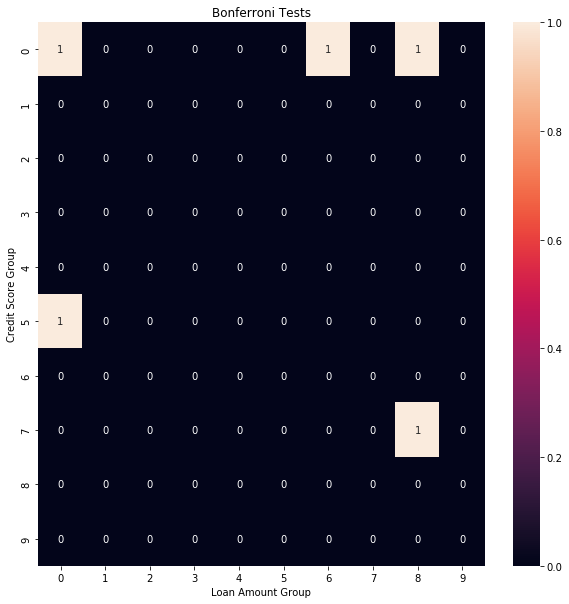

In [93]:
plt.figure(figsize=(10, 10))
plt.title('Bonferroni Tests')
sns.heatmap(bonferroni, annot=True)
plt.xlabel('Loan Amount Group')
plt.ylabel('Credit Score Group');

## BH correction 

The Bonferroni correction is often criticized for being too restrictive, as you probably noticed in the last subsection. A more commonly used method for correcting $\alpha$ values is the Benjamini-Hochberg method. You can <a href="https://www.youtube.com/watch?v=K8LQSvtjcEo">check out the quest</a> for a nice explanation about it.

Start by arranging the $p$-values of your original test as a series and listing them in ascending order. You can use the `pd.DataFrame.stack` and `pd.Series.sort_values` methods.

In [128]:
sorted_p_values = pd.Series(p_values.flatten(), name='p_values').sort_values()
old_idx = sorted_p_values.index
sorted_p_values.reset_index(drop=True, inplace=True)


Plot your sorted $p$-values

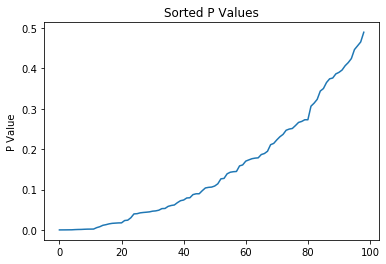

In [129]:
plt.title('Sorted P Values')
plt.ylabel('P Value')
plt.plot(sorted_p_values.values);

For each entry of the new series, compute the value compute the value $\frac{i}{m}\cdot\alpha$, where $i$ is the ordinal place of the entry (i.e. 1,2,...len(series)), $m=100$ and $\alpha=0.05$ as above. Add a plot of these values to your $p$-values plot.

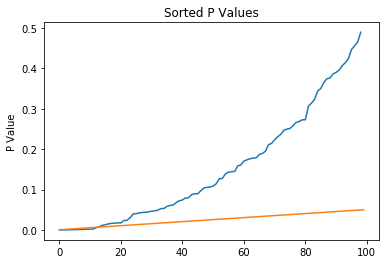

In [132]:
indices_divided = ((sorted_p_values.index + 1) * alpha) / len(sorted_p_values)

plt.title('Sorted P Values')
plt.ylabel('P Value')
plt.plot(sorted_p_values.values)
plt.plot(indices_divided);

Find the largest index $i$ for which the $p$-value in the $i$-th place in the series is smaller than $\frac{i}{m}\cdot\alpha$. That is- the last index in the plot you just created where the $p$-values line lies below the _adjusted_-$\alpha$ line.

In [134]:
largest_rejected = sorted_p_values[sorted_p_values < indices_divided].idxmax()
largest_rejected
print(f"Number of tests came out significant under BH correction: {largest_rejected + 1}")

Number of tests came out significant under BH correction: 13


Reject the null hypothesis for all test before and including this index, and accept it for all others. Reformat your table into a $10\times 10$ dataframe; for which bins did we get a significant result in the corrected test?

In [135]:
reject_h0 = np.zeros(100, dtype=bool)
reject_h0[:largest_rejected + 1] = True

reject_h0 = reject_h0[old_idx].reshape((10, 10))

Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

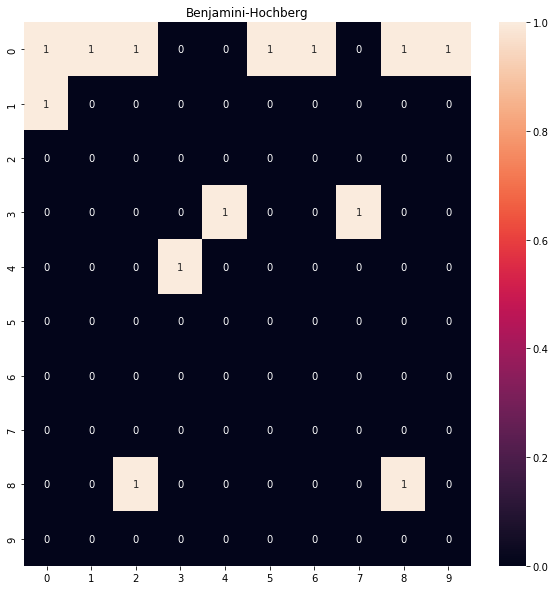

In [142]:
plt.figure(figsize=(10, 10))
plt.title('Benjamini-Hochberg')
sns.heatmap(reject_h0, annot=True);

* As we expected, the BH test accepted H1 in more tests than the Bonferroni test, which considered as more strict.

### Validating your results

You can validate your results (for both corrections) using the <a href= "https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html">`statsmodels.stats.multitest.multipletests`</a> package.

In [137]:
from statsmodels.stats.multitest import multipletests


Number of tests came out significant under Bonferroni correction validation: 5


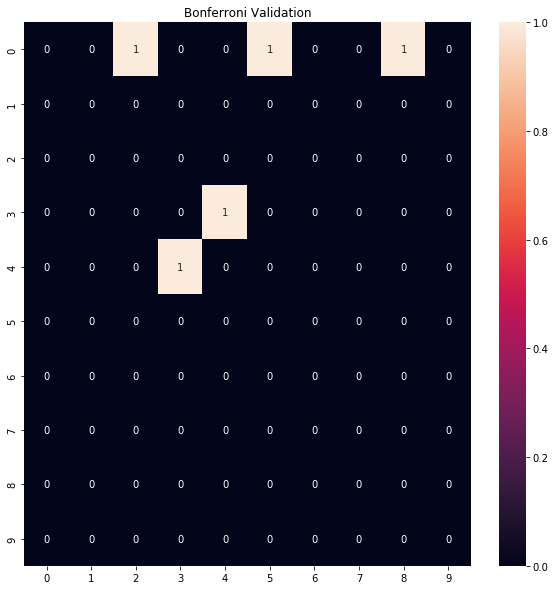

In [139]:
bonferroni_reject, _, _, _ = multipletests(sorted_p_values[old_idx], alpha=alpha, method='bonferroni')

print(f"Number of tests came out significant under Bonferroni correction validation: {bonferroni_reject.sum()}")

plt.figure(figsize=(10, 10))
plt.title('Bonferroni Validation')
sns.heatmap(bonferroni_reject.reshape((10, 10)), annot=True);


Number of tests came out significant under BH correction validation: 13


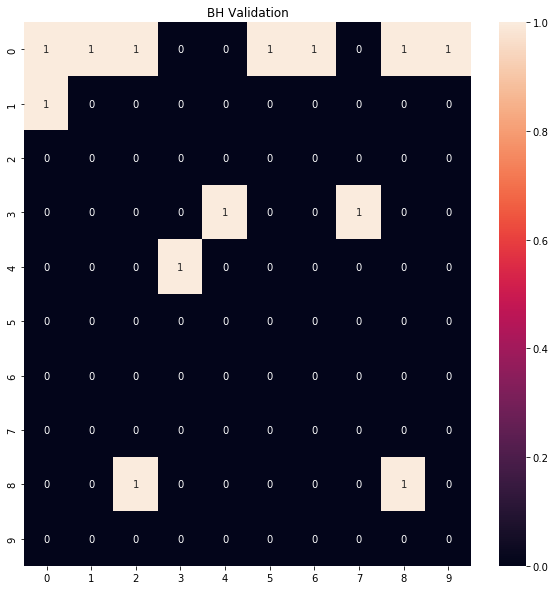

In [140]:
fdr_bh_reject, _, _, _ = multipletests(sorted_p_values[old_idx], alpha=alpha, method='fdr_bh')

print(f"Number of tests came out significant under BH correction validation: {fdr_bh_reject.sum()}")

plt.figure(figsize=(10, 10))
plt.title('BH Validation')
sns.heatmap(fdr_bh_reject.reshape((10, 10)), annot=True);

* Gladly, Our validation for BH produced identical results to our test in the previous section! \
  The Bonferroni validation produced the same amount of tests rejecting H0, but in different places